# Creación de una RED GAN para generar señales sinosuidales de 3 frecuencias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

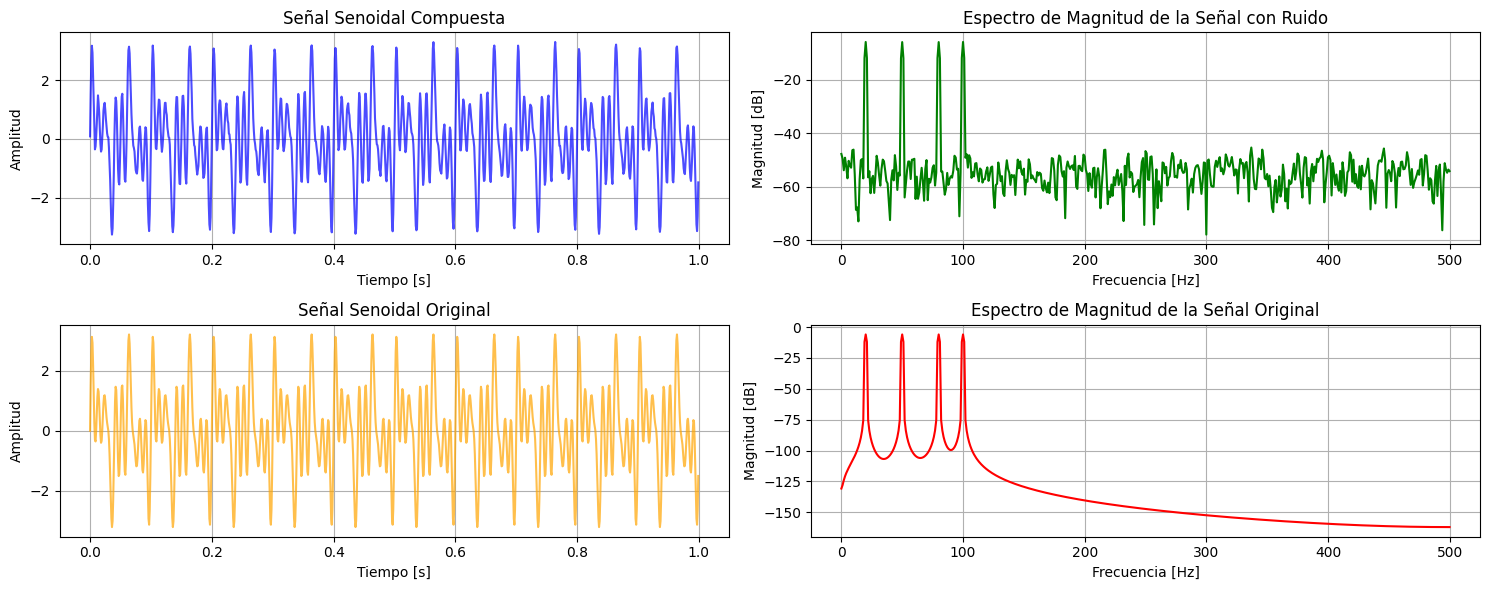

In [2]:
f1 = 20
f2 = 50
f3 = 100
f4 = 80

fs = 1e3
ts = 1/fs
N = 1000
n = np.arange(N)
t = n*ts

noise = np.random.uniform(-0.1, 0.1, N)
phi = np.random.randint(0, 3*np.pi/4)
phi1 = phi
phi2 = phi
phi3 = phi
phi4 = phi

x = np.sin(2*np.pi*f1*n*ts) + np.sin(2*np.pi*f2*n*ts) + np.sin(2*np.pi*f3*n*ts) + np.sin(2*np.pi*f4*n*ts) 
x_noised = np.sin(2*np.pi*f1*n*ts + phi1) + np.sin(2*np.pi*f2*n*ts +phi2) + np.sin(2*np.pi*f3*n*ts + phi3) + np.sin(2*np.pi*f4*n*ts + phi4) + noise

plt.figure(figsize=(15, 6))

plt.subplot(2,2,1)
plt.plot(t, x_noised, label='Señal con Ruido', color='blue', alpha=0.7)
plt.title('Señal Senoidal Compuesta')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid()

plt.subplot(2,2,2)
plt.magnitude_spectrum(x_noised, Fs=fs, scale='dB', color='green')
plt.title('Espectro de Magnitud de la Señal con Ruido')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.grid()

plt.subplot(2,2,3)
plt.plot(t, x, label='Señal Original', color='orange', alpha=0.7)
plt.title('Señal Senoidal Original')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid()

plt.subplot(2,2,4)
plt.magnitude_spectrum(x, Fs=fs, scale='dB', color='red')
plt.title('Espectro de Magnitud de la Señal Original')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.grid()

plt.tight_layout()
plt.show()

In [7]:
class Gen_DB_sin():
    def __init__(self, f=[20,50,100, 80], fs=1e3, duration=1.0, noise_std=0.02):
        self.f = f
        self.fs = fs
        self.duration = duration
        self.noise_std = noise_std
        self.ts = 1/fs
        self.n_samples = int(fs * duration)
        self.t = np.arange(self.n_samples) * self.ts

    def generate_single_sample(self):
        f1 = self.f[0]
        f2 = self.f[1]
        f3 = self.f[2]
        f4 = self.f[3]

        fs = 1e3
        ts = 1/fs
        
        N = self.n_samples
        n = np.arange(N)
        t = self.t #n*ts

        noise = np.random.uniform(-0.1, 0.1, N)
        phi = np.random.randint(0, 3*np.pi/4)
        phi1 = phi
        phi2 = phi
        phi3 = phi
        phi4 = phi

        #x = np.sin(2*np.pi*f1*n*ts) + np.sin(2*np.pi*f2*n*ts) + np.sin(2*np.pi*f3*n*ts) + np.sin(2*np.pi*f4*n*ts) 
        x_noised = np.sin(2*np.pi*f1*n*ts + phi1) + np.sin(2*np.pi*f2*n*ts +phi2) + np.sin(2*np.pi*f3*n*ts + phi3) + np.sin(2*np.pi*f4*n*ts + phi4) + noise
        return x_noised
    
    def generate_dataset(self, n_samples):
        X = []
        for _ in range(n_samples):
            x = self.generate_single_sample()
            X.append(x)
        return np.array(X)

In [8]:
Gen_DB_sin_instance = Gen_DB_sin(f=[20,50,100, 80], fs=1e3, duration=0.2, noise_std=0.02)
X_dataset = Gen_DB_sin_instance.generate_dataset(n_samples=1000)

X_dataset

array([[-0.05099769,  1.58661945,  2.70568594, ..., -3.03301241,
        -2.66283725, -1.42185259],
       [ 3.40643502,  3.87151736,  3.71838078, ..., -0.55617137,
         0.78196829,  2.19846212],
       [ 0.09427892,  1.58481255,  2.68083411, ..., -3.13381652,
        -2.58797261, -1.50542662],
       ...,
       [ 3.45230372,  3.94648461,  3.61276927, ..., -0.64235846,
         0.74272251,  2.23170402],
       [ 3.300352  ,  3.90849464,  3.60190686, ..., -0.53362393,
         0.8055982 ,  2.18589571],
       [ 3.2813339 ,  3.83230329,  3.60928617, ..., -0.57305346,
         0.74730297,  2.21878502]])

In [9]:
X_dataset.shape

(1000, 200)

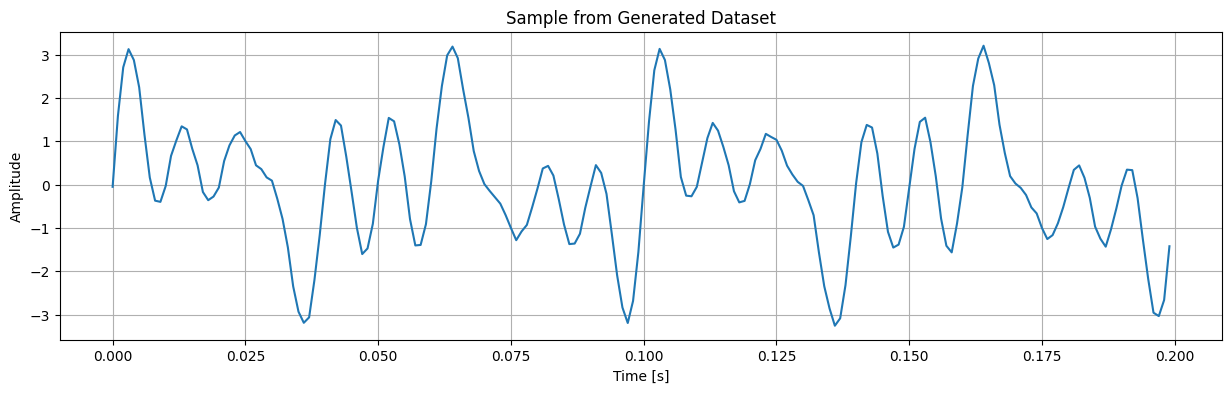

In [10]:
plt.figure(figsize=(15, 4))
plt.plot(Gen_DB_sin_instance.t, X_dataset[0,:])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Sample from Generated Dataset')
plt.grid()
plt.show()

## Dataloader en batch del dataset  de las señales

In [11]:
import torch
import torch.nn as nn
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 2025
torch.manual_seed(seed)
np.random.seed(seed)

class SineWaveDataset:
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]
    

def get_dataloader(data, batch_size=32, shuffle=True):
    dataset = SineWaveDataset(data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader


batch_size = 32
dataloader = get_dataloader(X_dataset, batch_size=batch_size, shuffle=True)




## Creación del GAN Vanilla

In [12]:
class Generator(nn.Module):
    def __init__(self, noise_dim=120, output_dim=1000):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)
    
class Discriminator(nn.Module):
    def __init__(self, input_dim=1000):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            #nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


Epoch [20/1000], D Loss: 0.0040, G Loss: 5.8672
Epoch [40/1000], D Loss: 0.0007, G Loss: 7.5009
Epoch [60/1000], D Loss: 0.0006, G Loss: 7.9794
Epoch [80/1000], D Loss: 0.0002, G Loss: 8.8995
Epoch [100/1000], D Loss: 0.0001, G Loss: 9.5828


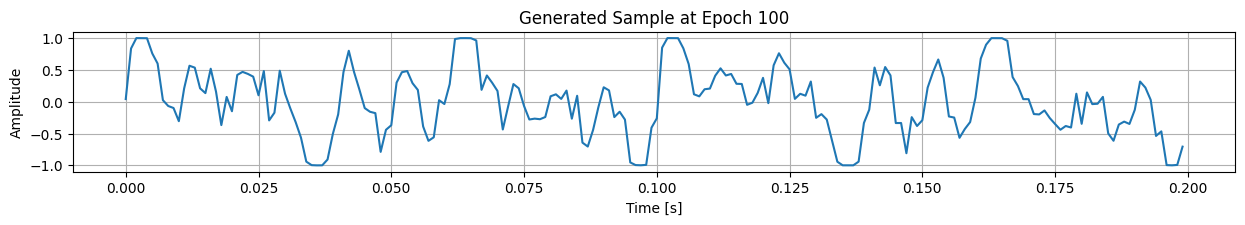

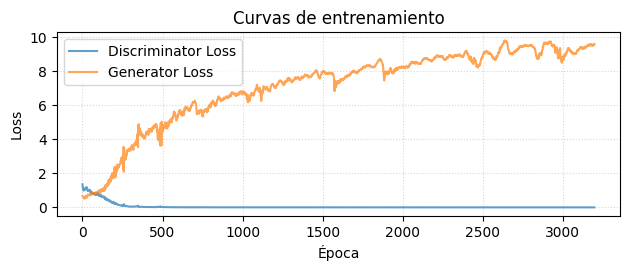

Epoch [120/1000], D Loss: 0.0001, G Loss: 9.5923
Epoch [140/1000], D Loss: 0.0000, G Loss: 10.9062
Epoch [160/1000], D Loss: 0.0000, G Loss: 10.8586
Epoch [180/1000], D Loss: 0.0000, G Loss: 11.7270
Epoch [200/1000], D Loss: 0.0000, G Loss: 11.6377


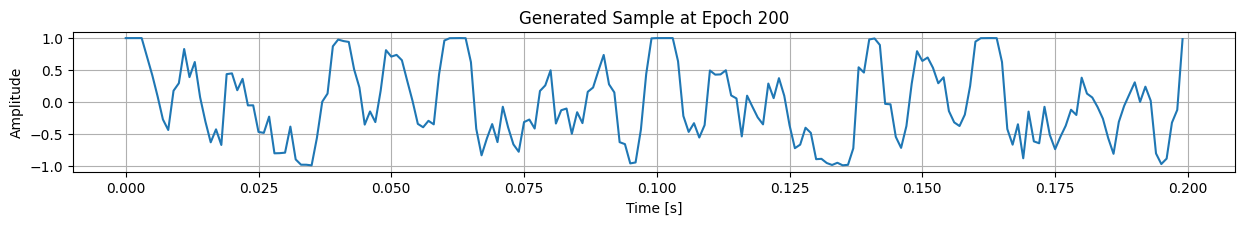

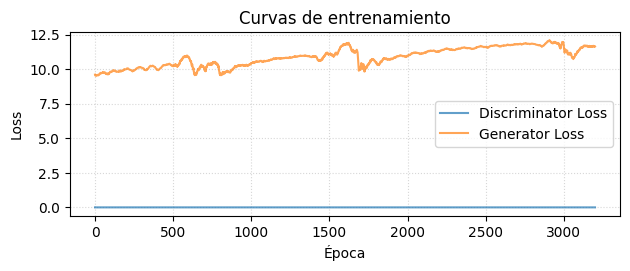

Epoch [220/1000], D Loss: 0.0000, G Loss: 12.6767
Epoch [240/1000], D Loss: 0.0000, G Loss: 12.4893
Epoch [260/1000], D Loss: 0.0000, G Loss: 12.8479
Epoch [280/1000], D Loss: 0.0000, G Loss: 13.7629
Epoch [300/1000], D Loss: 0.0000, G Loss: 13.1283


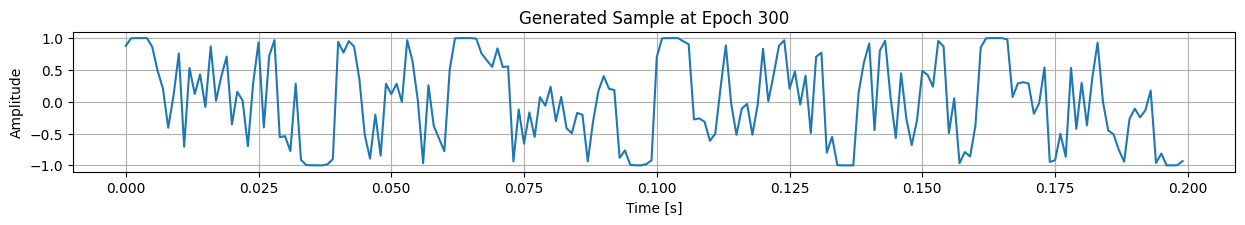

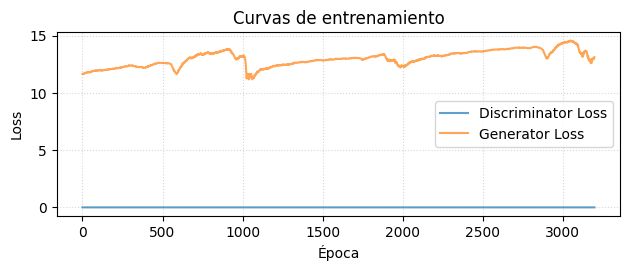

Epoch [320/1000], D Loss: 0.0000, G Loss: 14.3234
Epoch [340/1000], D Loss: 0.0000, G Loss: 14.8195
Epoch [360/1000], D Loss: 0.0000, G Loss: 14.2991
Epoch [380/1000], D Loss: 0.0000, G Loss: 15.4815
Epoch [400/1000], D Loss: 0.0000, G Loss: 15.9147


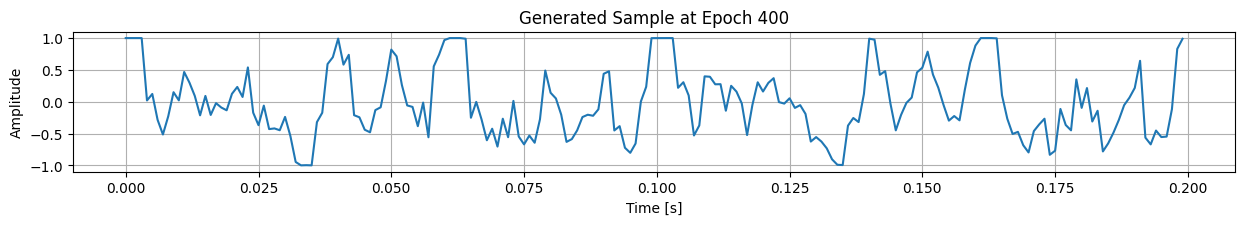

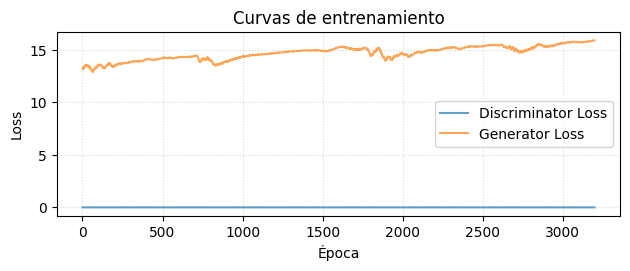

Epoch [420/1000], D Loss: 0.0000, G Loss: 15.8442
Epoch [440/1000], D Loss: 0.0000, G Loss: 16.6006
Epoch [460/1000], D Loss: 0.0000, G Loss: 16.2906
Epoch [480/1000], D Loss: 0.0000, G Loss: 18.0955
Epoch [500/1000], D Loss: 0.0000, G Loss: 17.7947


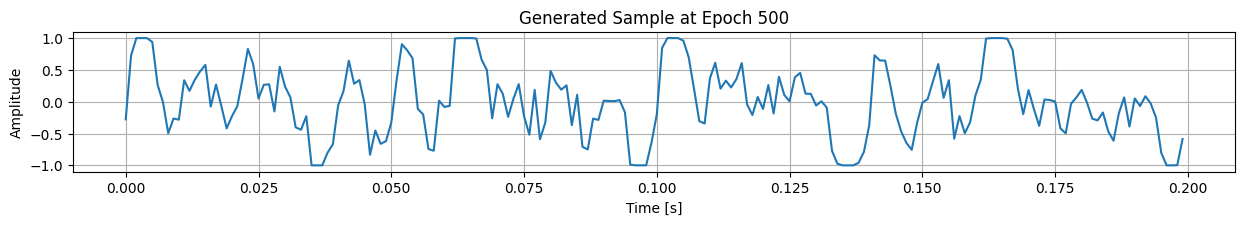

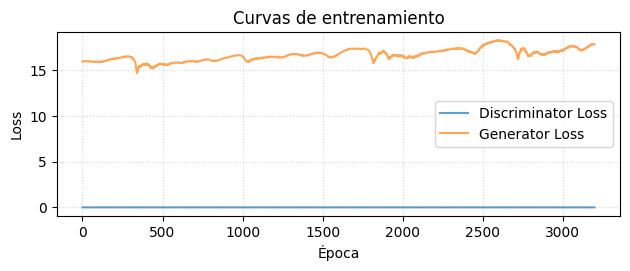

Epoch [520/1000], D Loss: 0.0000, G Loss: 17.3070
Epoch [540/1000], D Loss: 0.0000, G Loss: 18.6588
Epoch [560/1000], D Loss: 0.0000, G Loss: 17.3921
Epoch [580/1000], D Loss: 0.0000, G Loss: 19.2071
Epoch [600/1000], D Loss: 0.0000, G Loss: 20.2120


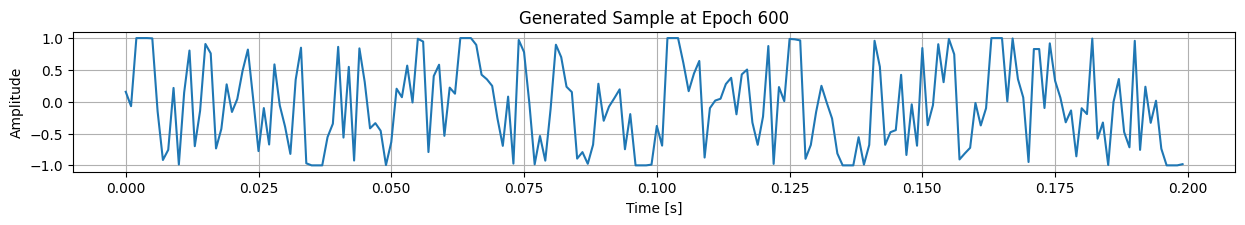

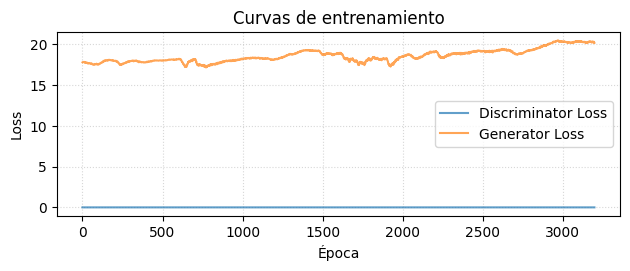

Epoch [620/1000], D Loss: 0.0000, G Loss: 19.4670
Epoch [640/1000], D Loss: 0.0000, G Loss: 19.6835
Epoch [660/1000], D Loss: 0.0000, G Loss: 19.9699
Epoch [680/1000], D Loss: 0.0000, G Loss: 21.1182
Epoch [700/1000], D Loss: 0.0000, G Loss: 21.1144


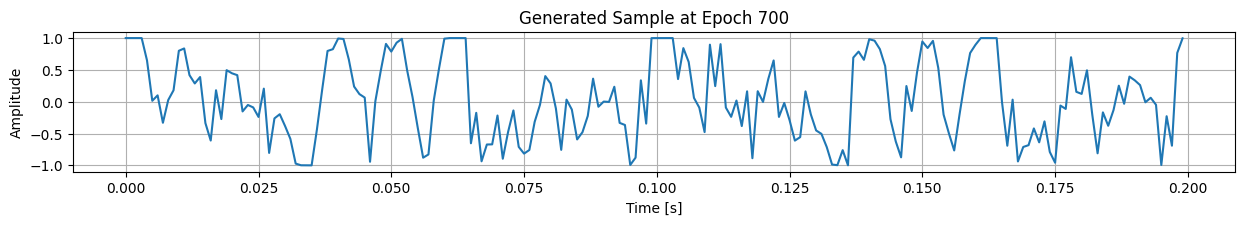

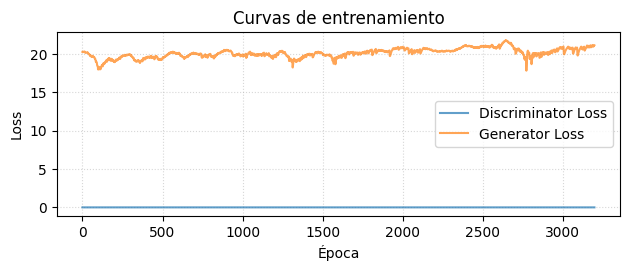

Epoch [720/1000], D Loss: 0.0000, G Loss: 22.0198
Epoch [740/1000], D Loss: 0.0000, G Loss: 22.6628
Epoch [760/1000], D Loss: 0.0000, G Loss: 21.3147
Epoch [780/1000], D Loss: 0.0000, G Loss: 22.2343
Epoch [800/1000], D Loss: 0.0000, G Loss: 23.4598


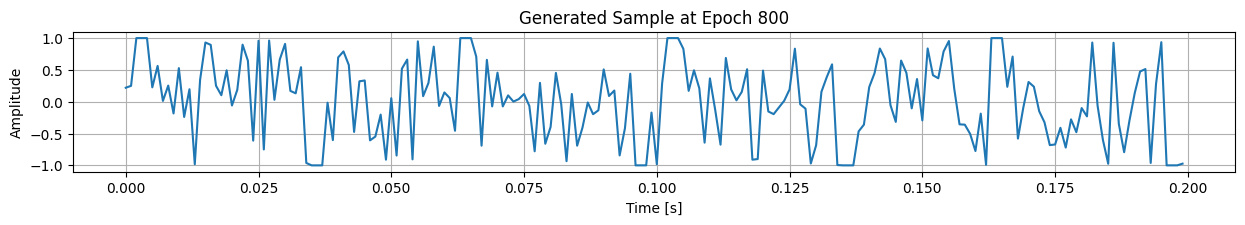

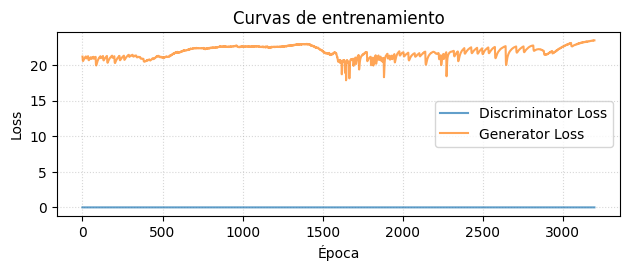

Epoch [820/1000], D Loss: 0.0000, G Loss: 20.8540
Epoch [840/1000], D Loss: 0.0000, G Loss: 22.8205
Epoch [860/1000], D Loss: 0.0000, G Loss: 21.6669
Epoch [880/1000], D Loss: 0.0000, G Loss: 22.3142
Epoch [900/1000], D Loss: 0.0000, G Loss: 23.3273


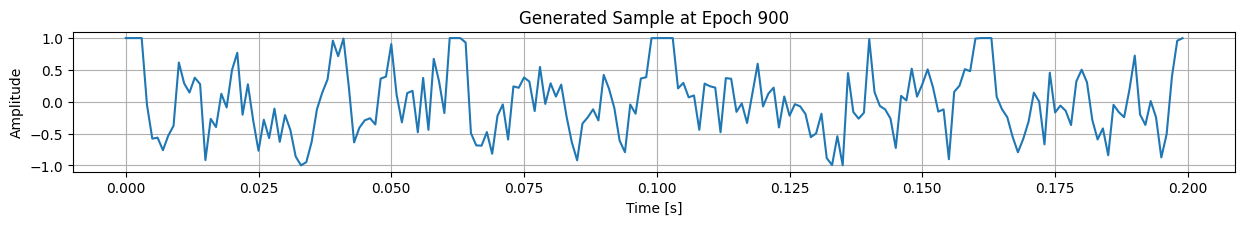

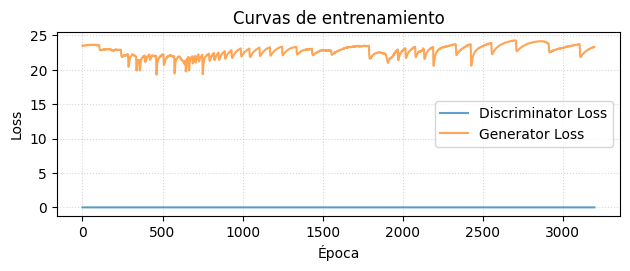

Epoch [920/1000], D Loss: 0.0000, G Loss: 23.3101
Epoch [940/1000], D Loss: 0.0000, G Loss: 22.6053
Epoch [960/1000], D Loss: 0.0000, G Loss: 24.2790
Epoch [980/1000], D Loss: 0.0000, G Loss: 23.2207
Epoch [1000/1000], D Loss: 0.0000, G Loss: 24.8343


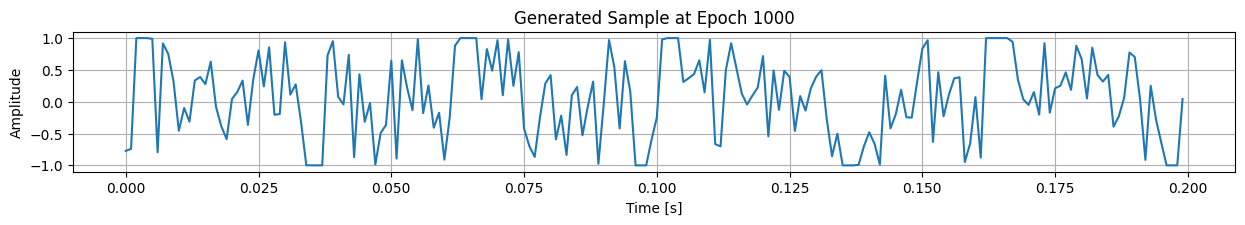

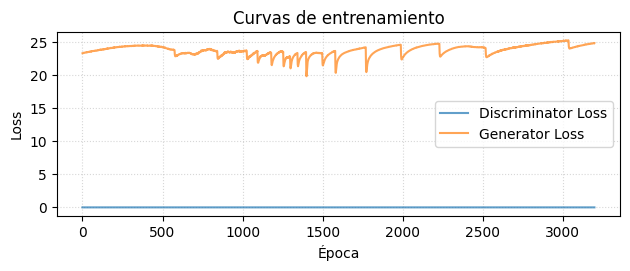

***************** Training finished!!! ****************


In [13]:
class Trainer:
    def __init__(self, generator, discriminator, g_optimizer, d_optimizer, criterion, device):
        self.generator = generator
        self.discriminator = discriminator
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.criterion = criterion
        self.device = device

    def train_step(self, real_data):
        batch_size = real_data.size(0)
        real_data = real_data.to(self.device)

        # Train Discriminator
        self.d_optimizer.zero_grad()

        # Real data
        real_labels = torch.ones(batch_size, 1).to(self.device)
        real_outputs = self.discriminator(real_data)
        d_loss_real = self.criterion(real_outputs, real_labels)

        # Fake data
        noise = torch.randn(batch_size, 100).to(self.device)
        fake_data = self.generator(noise)
        fake_labels = torch.zeros(batch_size, 1).to(self.device)
        fake_outputs = self.discriminator(fake_data.detach())
        d_loss_fake = self.criterion(fake_outputs, fake_labels)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        self.d_optimizer.step()

        # Train Generator
        self.g_optimizer.zero_grad()
        fake_outputs = self.discriminator(fake_data)
        g_loss = self.criterion(fake_outputs, real_labels)
        g_loss.backward()
        self.g_optimizer.step()

        return d_loss.item(), g_loss.item()

## Creacion del GAN vanilla
noise_dim = 100
output_dim = X_dataset.shape[1]

generator = Generator(noise_dim=noise_dim, output_dim=output_dim).to(device)
discriminator = Discriminator(input_dim=output_dim).to(device)

g_optimizer = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCEWithLogitsLoss()

trainer = Trainer(generator, discriminator, g_optimizer, d_optimizer, criterion, device)

num_epochs = 1000
g_errors = []
d_errors = []


EPOCHS_TO_PLOT = 100
LOSS_MAX_VIEW = batch_size * EPOCHS_TO_PLOT

for epoch in range(num_epochs):
    for real_data in dataloader:
        d_loss, g_loss = trainer.train_step(real_data)
        d_errors.append(d_loss)
        g_errors.append(g_loss)

    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}')

    if (epoch+1) % EPOCHS_TO_PLOT == 0:
        plt.figure(figsize=(15, 4))
        noise = torch.randn(1, noise_dim).to(device)
        generated_data = generator(noise).cpu().detach().numpy().reshape(-1)

        plt.subplot(2, 1, 1)
        plt.plot(Gen_DB_sin_instance.t, generated_data)
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
        plt.title(f'Generated Sample at Epoch {epoch+1}')
        plt.grid()
        plt.show()

         # Graficar curvas de pérdida
        plt.subplot(2, 1, 2)
        plt.plot(d_errors[len(d_errors)-LOSS_MAX_VIEW:], label='Discriminator Loss', alpha=0.7)
        plt.plot(g_errors[len(g_errors)-LOSS_MAX_VIEW:], label='Generator Loss', alpha=0.7)
        plt.xlabel('Época')
        plt.ylabel('Loss')
        plt.title('Curvas de entrenamiento')
        plt.legend()
        plt.grid(ls=":", alpha=0.5)
        
        plt.tight_layout()
        plt.show()

print("***************** Training finished!!! ****************")


## Test nueva data generada

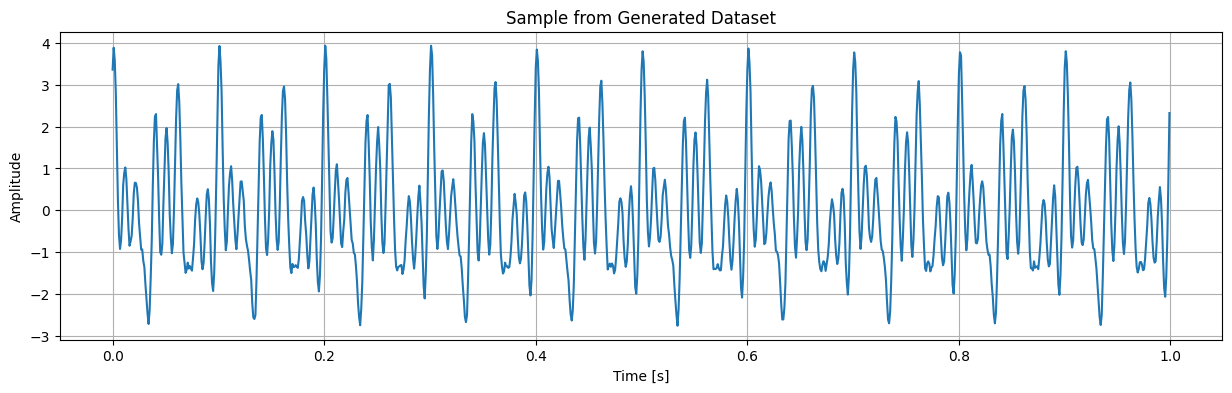

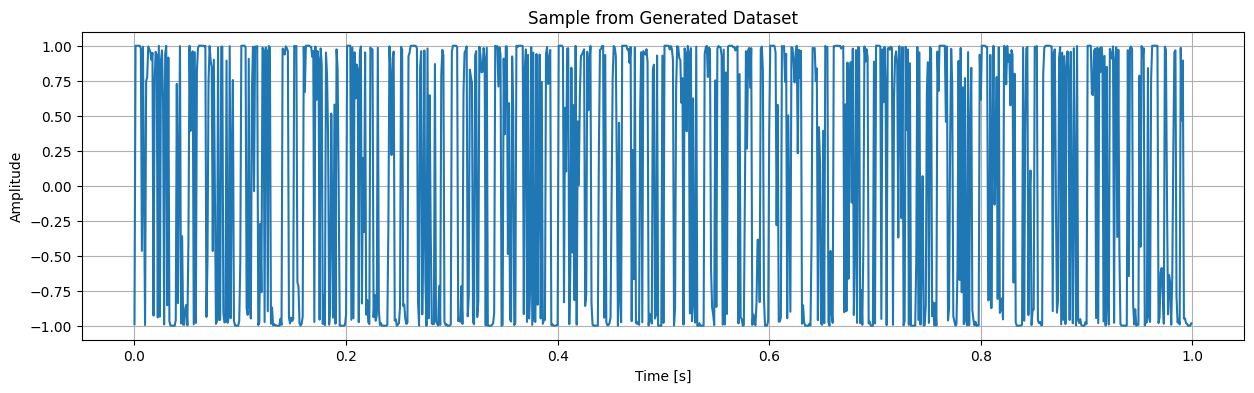

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(Gen_DB_sin_instance.t, X_dataset[0,:])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Sample from Generated Dataset')
plt.grid()
plt.show()

noise = torch.randn(1, noise_dim).to(device)
generated_data2 = generator(noise).cpu().detach().numpy().reshape(-1)


plt.figure(figsize=(15, 4))
plt.plot(Gen_DB_sin_instance.t, generated_data2)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Sample from Generated Dataset')
plt.grid()
plt.show()